# Import Packages

In [1]:
import pandas as pd
import numpy as np

import librosa as lr
import librosa.display

import IPython.display as ipd

import zipfile

import noisereduce as nr

import sklearn as sk

import matplotlib.pylab as plt

C:\Users\eboci_000\Anaconda3\lib\site-packages\tqdm\autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


# Load Data

###### Unzip the Main File

In [2]:
#This code was only needed once.
#The data had to be uploaded as a zip file, 
#then unpackaged in the workspace.

#Location of .zip Files
#data_dir = 'whale_data.zip'

#Unzip files.
#with zipfile.ZipFile(data_dir,"r") as z:
    #z.extractall(".")

###### Load the csv containing the labels.

In [3]:
#File location
labels_file = 'data/train.csv'

#Load label file.
labels = pd.read_csv(labels_file)

#Check that it loaded correctly.
labels.head(10)

,clip_name,label
0,train1.aiff,0
1,train2.aiff,0
2,train3.aiff,0
3,train4.aiff,0
4,train5.aiff,0
5,train6.aiff,1
6,train7.aiff,1
7,train8.aiff,0
8,train9.aiff,1
9,train10.aiff,0


###### Convert file to labels and file locations, y and X for the modeling process.

In [4]:
df = labels

audio_location = 'data/train'

df['file'] = audio_location+'/'+df['clip_name']

df.head(10)

,clip_name,label,file
0,train1.aiff,0,data/train/train1.aiff
1,train2.aiff,0,data/train/train2.aiff
2,train3.aiff,0,data/train/train3.aiff
3,train4.aiff,0,data/train/train4.aiff
4,train5.aiff,0,data/train/train5.aiff
5,train6.aiff,1,data/train/train6.aiff
6,train7.aiff,1,data/train/train7.aiff
7,train8.aiff,0,data/train/train8.aiff
8,train9.aiff,1,data/train/train9.aiff
9,train10.aiff,0,data/train/train10.aiff


In [5]:
df = df[['file','label']]
df.head(10)

,file,label
0,data/train/train1.aiff,0
1,data/train/train2.aiff,0
2,data/train/train3.aiff,0
3,data/train/train4.aiff,0
4,data/train/train5.aiff,0
5,data/train/train6.aiff,1
6,data/train/train7.aiff,1
7,data/train/train8.aiff,0
8,data/train/train9.aiff,1
9,data/train/train10.aiff,0


In [6]:
#Save to file for 

df.to_csv('labels.csv')

# About the Data

In [7]:
print("Number of audio files =", df.shape[0])

Number of audio files = 30000


###### Audio File Parameters

In [8]:
import aifc

obj = aifc.open('data/train/train1.aiff', 'r')

obj.getparams()

#If these were not the same for all files, could use this to create
#a table for further preprocessing. However, all files are already consistent.

_aifc_params(nchannels=1, sampwidth=2, framerate=2000, nframes=4000, comptype=b'NONE', compname=b'not compressed')

In [9]:
#Set framerate(samplerate)
sr = obj.getframerate()
sr

2000

###### Distribution of Categories - 1 indicates whale signal

In [10]:
df.groupby('label').count()

,file
label,
0,22973
1,7027


# Visualizing Audio

Preprocessing of audio data involves resolving issues of noisness and varying time durations. In this case, the data is already consistently 2 second clips, so the main concern is noisiness.

### View Data Before Any Processing

In [11]:
#Set samplerate for visuals.
srv = 44000

##### View and listen to an audio that does not contain a whale signal.

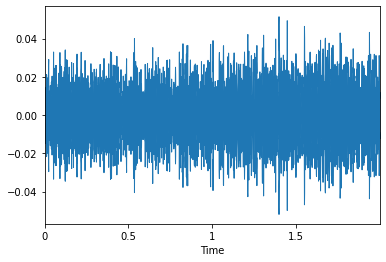

In [12]:
#From the label list it is seen that the first file does not contain a whale signal.
audio, sfreq = lr.load(df['file'][0], sr=srv)
librosa.display.waveplot(audio, sr=srv);

In [13]:
ipd.Audio(audio, rate=srv)

This file does not contain any distinct sounds and may only be the static sounds of the ocean.

###### View and listen to an audio file that does contain a whale signal.

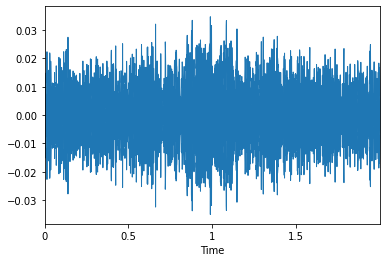

In [14]:
audio, sfreq = lr.load(df['file'][5], sr=srv)
librosa.display.waveplot(audio, sr=srv);

In [15]:
#Listen to whale audio.
ipd.Audio(audio, rate=srv)

Visually, it is difficult to see that this file contains a whale signal. However, listening to the audio confirms that a whale is making a sound at about 1 second.

### Isolating Whale Signals

##### Split the files by category

In [16]:
#Filter by label.
whale = df[df['label']==1].reset_index()
noise = df[df['label']==0].reset_index()

In [17]:
#Keep only the file location column.
whale = whale['file']
noise = noise['file']

In [18]:
#Verify that the data is in the correct format.
print(whale.head())
print('')
print(noise.head())

0     data/train/train6.aiff
1     data/train/train7.aiff
2     data/train/train9.aiff
3    data/train/train12.aiff
4    data/train/train28.aiff
Name: file, dtype: object

0    data/train/train1.aiff
1    data/train/train2.aiff
2    data/train/train3.aiff
3    data/train/train4.aiff
4    data/train/train5.aiff
Name: file, dtype: object


### Perform simple noisereudction.

More information on how this package removes noise can be found at:
https://pypi.org/project/noisereduce/

In [19]:
audio, sfreq = lr.load(whale[0], sr=srv)
whale_audio = audio

audio, sfreq = lr.load(noise[0], sr=srv)
noise_audio = audio

In [20]:
reduced_noise = nr.reduce_noise(audio_clip = whale_audio,
                               noise_clip = noise_audio, verbose = False)

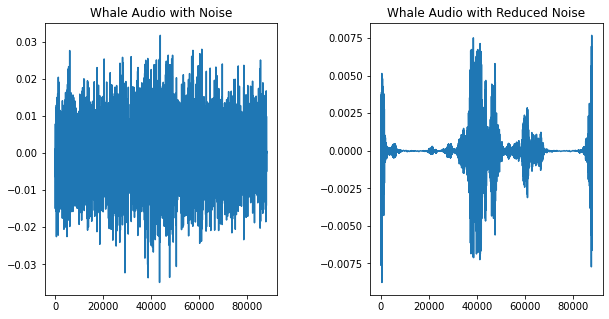

In [21]:
plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
plt.plot(whale_audio)
plt.title('Whale Audio with Noise')

plt.subplot(1,2,2)
plt.plot(reduced_noise)
plt.title('Whale Audio with Reduced Noise')

plt.subplots_adjust(wspace=0.4, hspace=0.4)

plt.show();

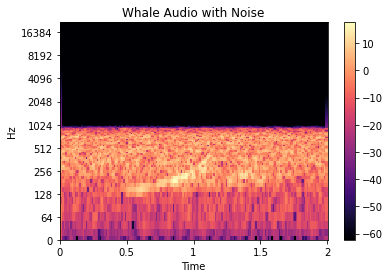

In [22]:
X1 = librosa.stft(whale_audio)
Xdb1 = librosa.amplitude_to_db(abs(X1))

X2 = librosa.stft(reduced_noise)
Xdb2 = librosa.amplitude_to_db(abs(X2))


fig, ax = plt.subplots()
img = librosa.display.specshow(Xdb1, sr=srv, x_axis='time', y_axis='log', ax=ax)
ax.set(title = 'Whale Audio with Noise')
plt.colorbar(img, ax=ax);

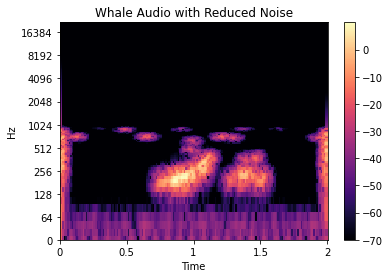

In [23]:
fig, ax = plt.subplots()
img = librosa.display.specshow(Xdb2, sr=srv, x_axis='time', y_axis='log')
ax.set(title = 'Whale Audio with Reduced Noise')
plt.colorbar(img, ax=ax);

Noise helps to prevent overfitting and as it only took one file to be able to clearly see the whale signal. No further noisereduction is needed.

### Spectral Centroids

The spectral centroid is a measure used to characterise an audio spectrum by finding its center of mass. It is also connected to the brightness of a sound, which refers to the higher mid and treble parts of the frequency. 
https://www.kaggle.com/oakmin/audio-data-exploration

In [24]:
#Load a whale audio file.
audio, sfreq = lr.load(whale[0], sr=srv)
whale_audio = audio

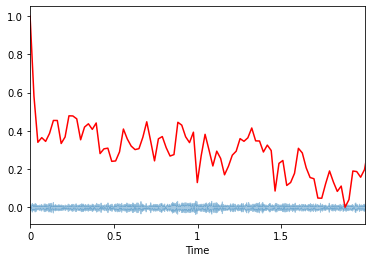

In [25]:
spectral_centroids = librosa.feature.spectral_centroid(whale_audio, sr=srv)[0]
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)
def normalize(y_, axis=0):
    return sk.preprocessing.minmax_scale(y_, axis=axis)
librosa.display.waveplot(whale_audio, sr=srv, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='r') # normalize for visualization purposes
plt.show()

Without doing any noise reduction, there are still visual indicators of where whale sounds are occuring. When listening to this  specific file, there are two distinct sounds around 1s and right before 1.5s. In this visual, there are distinct descreases at those points.

Let's see if a similar pattern holds up with other audio clips.

In [41]:
audio, sfreq = lr.load(whale[500], sr=srv)
w1 = audio

audio, sfreq = lr.load(whale[1000], sr=srv)
w2 = audio

audio, sfreq = lr.load(whale[3500], sr=srv)
w3 = audio

audio, sfreq = lr.load(whale[7000], sr=srv)
w4 = audio

##### Example One

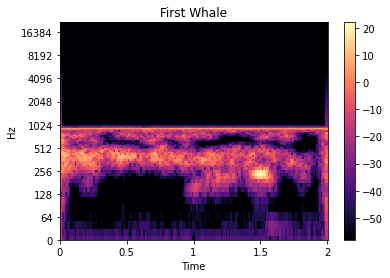

In [33]:
r1 = nr.reduce_noise(audio_clip = w1, noise_clip = noise_audio, verbose = False)

X = librosa.stft(r1)
Xdb = librosa.amplitude_to_db(abs(X))

fig, ax = plt.subplots()
img = librosa.display.specshow(Xdb, sr=srv, x_axis='time', y_axis='log')
ax.set(title = 'First Whale')
plt.colorbar(img, ax=ax);

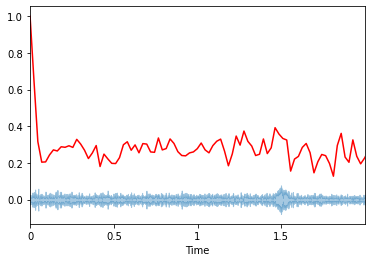

In [27]:
spectral_centroids = librosa.feature.spectral_centroid(w1, sr=srv)[0]
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)
librosa.display.waveplot(w1, sr=srv, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='r') # normalize for visualization purposes
plt.show()

#### Example Two

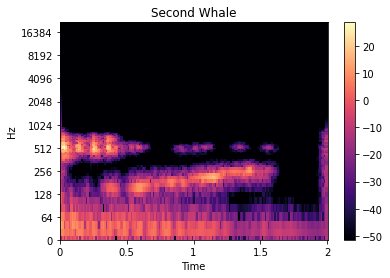

In [40]:
r2 = nr.reduce_noise(audio_clip = w2, noise_clip = noise_audio, verbose = False)

X = librosa.stft(r2)
Xdb = librosa.amplitude_to_db(abs(X))

fig, ax = plt.subplots()
img = librosa.display.specshow(Xdb, sr=srv, x_axis='time', y_axis='log')
ax.set(title = 'Second Whale')
plt.colorbar(img, ax=ax);

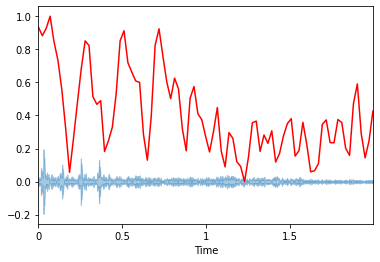

In [28]:
spectral_centroids = librosa.feature.spectral_centroid(w2, sr=srv)[0]
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)
librosa.display.waveplot(w2, sr=srv, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='r') # normalize for visualization purposes
plt.show()

##### Example Three

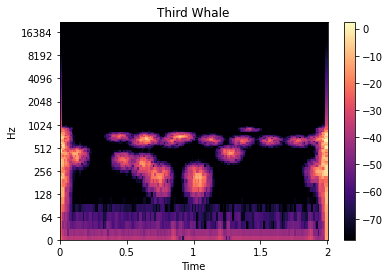

In [42]:
r3 = nr.reduce_noise(audio_clip = w3, noise_clip = noise_audio, verbose = False)

X = librosa.stft(r3)
Xdb = librosa.amplitude_to_db(abs(X))

fig, ax = plt.subplots()
img = librosa.display.specshow(Xdb, sr=srv, x_axis='time', y_axis='log')
ax.set(title = 'Third Whale')
plt.colorbar(img, ax=ax);

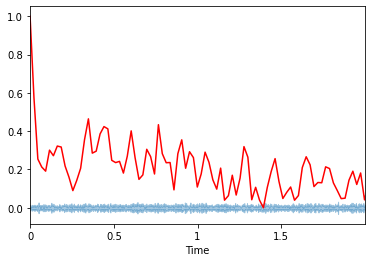

In [43]:
spectral_centroids = librosa.feature.spectral_centroid(w3, sr=srv)[0]
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)
librosa.display.waveplot(w3, sr=srv, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='r') # normalize for visualization purposes
plt.show()

##### Fourth Whale

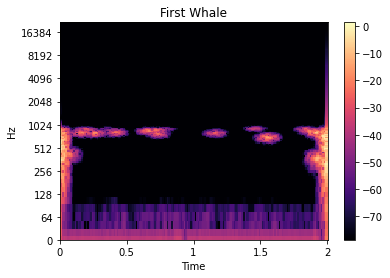

In [45]:
r4 = nr.reduce_noise(audio_clip = w4, noise_clip = noise_audio, verbose = False)

X = librosa.stft(r4)
Xdb = librosa.amplitude_to_db(abs(X))

fig, ax = plt.subplots()
img = librosa.display.specshow(Xdb, sr=srv, x_axis='time', y_axis='log')
ax.set(title = 'First Whale')
plt.colorbar(img, ax=ax);

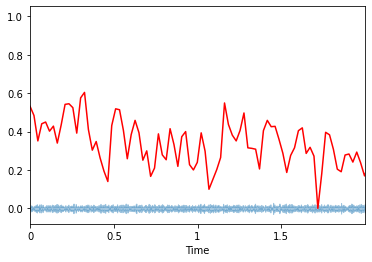

In [52]:
spectral_centroids = librosa.feature.spectral_centroid(w4, sr=srv)[0]
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)
librosa.display.waveplot(w4, sr=srv, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='r') # normalize for visualization purposes
plt.show()

Not all the whale clips are as simple to visualize as others, but there does seem to be a common trend where the centroids drop around or below 0.2 when there is a presence of a whale signal.

### Spectral Rolloff

It is a measure of the shape of the signal. It represents the frequency at which high frequencies decline to 0. To obtain it, we have to calculate the fraction of bins in the power spectrum where 85% of its power is at lower frequencies.

https://www.kdnuggets.com/2020/02/audio-data-analysis-deep-learning-python-part-1.html

As seen from the spectral centroids, this could be a key feature for this study as many whale calls are lower frequency. It can not be the only consideration as clicks and whistles tend to have higher frequencies than pulsed calls.

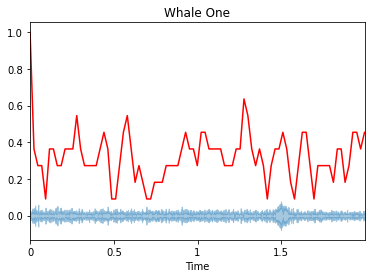

In [77]:
spectral_rolloff = librosa.feature.spectral_rolloff(w1+0.01, sr=srv)[0]
librosa.display.waveplot(w1, sr=srv, alpha=0.4)
plt.plot(t, normalize(spectral_rolloff), color='r')
plt.title('Whale One');

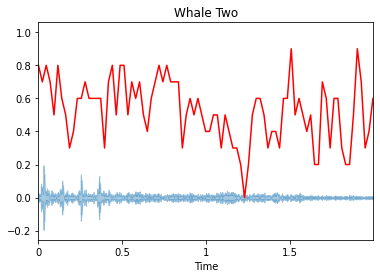

In [78]:
spectral_rolloff = librosa.feature.spectral_rolloff(w2+0.01, sr=srv)[0]
librosa.display.waveplot(w2, sr=srv, alpha=0.4)
plt.plot(t, normalize(spectral_rolloff), color='r')
plt.title('Whale Two');

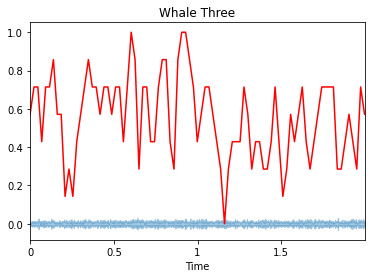

In [79]:
spectral_rolloff = librosa.feature.spectral_rolloff(w3+0.01, sr=srv)[0]
librosa.display.waveplot(w3, sr=srv, alpha=0.4)
plt.plot(t, normalize(spectral_rolloff), color='r')
plt.title('Whale Three');

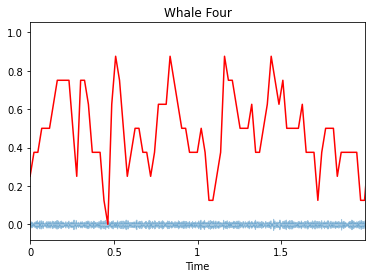

In [80]:
spectral_rolloff = librosa.feature.spectral_rolloff(w4+0.01, sr=srv)[0]
librosa.display.waveplot(w4, sr=srv, alpha=0.4)
plt.plot(t, normalize(spectral_rolloff), color='r')
plt.title('Whale Four');

With the exception of the first whale, there are points that reach 0. Even with the first whale, it may not reach 0, but it does still is close.

### Chroma

A chroma feature or vector is typically a 12-element feature vector indicating how much energy of each pitch class, {C, C#, D, D#, E, …, B}, is present in the signal. https://www.kdnuggets.com/2020/02/audio-data-analysis-deep-learning-python-part-1.html

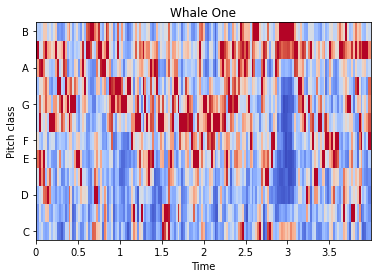

In [72]:
chromagram = librosa.feature.chroma_stft(w1, sr=srv)
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', cmap='coolwarm')
plt.title('Whale One');

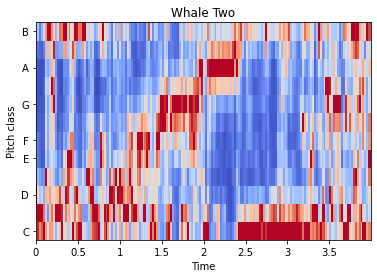

In [73]:
chromagram = librosa.feature.chroma_stft(w2, sr=srv)
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', cmap='coolwarm')
plt.title('Whale Two');

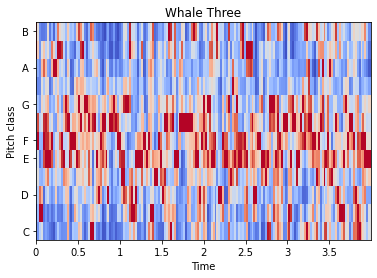

In [74]:
chromagram = librosa.feature.chroma_stft(w3, sr=srv)
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', cmap='coolwarm')
plt.title('Whale Three');

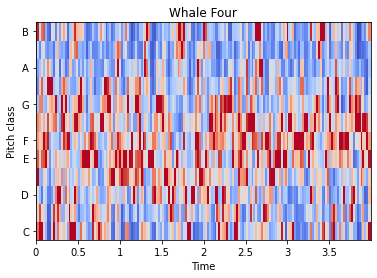

In [75]:
chromagram = librosa.feature.chroma_stft(w4, sr=srv)
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', cmap='coolwarm')
plt.title('Whale Four');

Pitch itself does is not an apparent trend in pitch itself. However, the movement of pitch, as clearly seen with whale two, can indicate certain kinds of whale sounds.